In [1]:
# import packages and add global parameter settings
import re
import json
import numpy as np
from io import StringIO
from tqdm.auto import tqdm
import wandb
import string
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from matplotlib.ticker import FuncFormatter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict


sb.set_theme(style="white", palette=None)

C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# connect to wandb and get list of runs
api_helper = wandb.Api(api_key='3138e1b24deb278ed045d0dedb39511d3a96245b')
runs = list(api_helper.runs(path='yuting_fyp/In-context-learning for Dialogue Summarization',
                     per_page=1000))
runs

[<Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/znfph1r8 (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/7g29utle (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/sztpd82u (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/obg7g54g (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/avbkuk6f (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/wyy1ypxj (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/5g5ap7y4 (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/ruskmd5k (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/x84owtic (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/3424bv3i (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/3dh8hbgw (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summa

In [11]:
# iterate over completed runs to get ROUGE scores tables
run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or 'evaluation' != getattr(run, 'job_type', ''):
        continue
    else:
        print('parsing run {}'.format(run.name))
    # download the rouge table
    files = run.files()
    metric_file = [file for file in files if 'Evaluation metrics Table' in getattr(file, 'name', '')]
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) < 1'.format(metric_file))
        continue
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metric_table = pd.read_json(json.dumps(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
        metric_table['k'] = k
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue 
    model_name = run.name[: start_i - 1]
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/281 [00:00<?, ?it/s]

parsing run llama-7b-hf-0-shot
parsing run opt-iml-1.3b-2-shot-randomLabel
parsing run Cerebras-GPT-13B-3-shot-length
parsing run mt5-xl-1-shot-3-keywords-raw
[debug] find keyword_num = 3 in mt5-xl-1-shot-3-keywords-raw
parsing run alpaca-native-3-shot-length
parsing run alpaca-native-3-shot-3-keywords
[debug] find keyword_num = 3 in alpaca-native-3-shot-3-keywords
parsing run opt-1.3b-2-shot-focus
parsing run alpaca-native-2-shot-3-keywords
[debug] find keyword_num = 3 in alpaca-native-2-shot-3-keywords
parsing run mt5-xl-1-shot-length
parsing run mt5-xl-2-shot-length
parsing run mt5-xl-3-shot-length
parsing run Cerebras-GPT-13B-1-shot-length
parsing run opt-1.3b-3-shot-focus
parsing run opt-1.3b-1-shot-focus
parsing run mt5-xl-3-shot-raw
parsing run opt-iml-1.3b-3-shot-focus
parsing run GPT3-davinci-003-2-shot-3-keywords
[debug] find keyword_num = 3 in GPT3-davinci-003-2-shot-3-keywords
parsing run GPT3-davinci-003-2-shot-3-keywords
[WARN] skip [] because len(metric_file) < 1
parsing

[debug] find keyword_num = 3 in bloom-7b1-3-shot-3-keywords
parsing run bloom-7b1-3-shot-2-keywords
[debug] find keyword_num = 2 in bloom-7b1-3-shot-2-keywords
parsing run bloom-7b1-3-shot-1-keywords
[debug] find keyword_num = 1 in bloom-7b1-3-shot-1-keywords
parsing run bloom-7b1-2-shot-3-keywords
[debug] find keyword_num = 3 in bloom-7b1-2-shot-3-keywords
parsing run bloom-7b1-2-shot-2-keywords
[debug] find keyword_num = 2 in bloom-7b1-2-shot-2-keywords
parsing run bloom-7b1-2-shot-1-keywords
[debug] find keyword_num = 1 in bloom-7b1-2-shot-1-keywords
parsing run bloom-7b1-1-shot-3-keywords
[debug] find keyword_num = 3 in bloom-7b1-1-shot-3-keywords
parsing run bloom-7b1-1-shot-1-keywords
[debug] find keyword_num = 1 in bloom-7b1-1-shot-1-keywords
parsing run bloom-7b1-1-shot-2-keywords
[debug] find keyword_num = 2 in bloom-7b1-1-shot-2-keywords
parsing run flan-t5-xl-3-shot
parsing run flan-t5-xl-3-shot
parsing run flan-t5-xl-2-shot
parsing run flan-t5-xl-2-shot
parsing run alpaca-n

{'llama-7b-hf-0-shot':    run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
 0       0           0.392085        0.210658          0.257814   
 
    rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  rouge_L_precision  \
 0           0.090686        0.044516          0.056308           0.295086   
 
    rouge_L_recall  rouge_L_fmeasure  k   model_name keyword_num  
 0         0.15359          0.189891  0  llama-7b-hf        None  ,
 'opt-iml-1.3b-2-shot-randomLabel':    run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
 0       0           0.254038        0.541792          0.323467   
 1       1           0.250447        0.532532          0.318229   
 2       2           0.255916        0.544776          0.326354   
 3       3           0.259374        0.552865          0.330481   
 4       4           0.248244        0.530279          0.316266   
 
    rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  rouge_L_precision  \
 0           0.070903        0.1

# Direct prompt

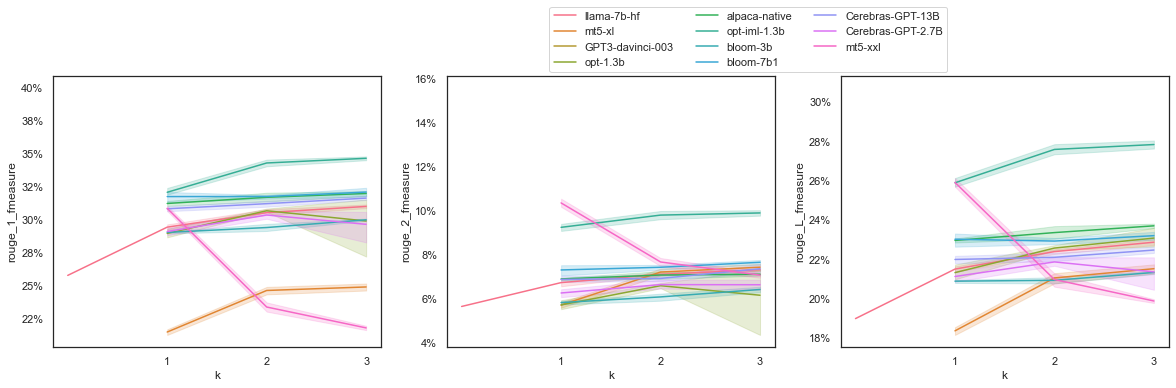

In [14]:
# parse the result of direct prompt
new_keys = [x for x in run2metric_table.keys() if ('keyword' not in x and 'nameReplace' not in x and 'length' 
                                                   not in x and 'replaceName' not in x and 'instructions' not in x and 
                                                  'focus' not in x and 'randomLabel' not in x)]
# new_keys = [x for x in run2metric_table.keys() if ('keyword' not in x and 'nameReplace' not in x and 'length' not
#                                                     in x and 'replaceName' not in x and 'instructions' not in x and 'focus' in x)]

dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table = rouge_table[(rouge_table['k'] <= 3) & ~rouge_table.isna().any(axis=1)]
rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B') & ~rouge_table['model_name'].str.contains('flan-t5-xl')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='model_name', ax=axes[0], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='model_name', ax=axes[1], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].get_legend().remove()
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='model_name', ax=axes[2], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].get_legend().remove()
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=3, bbox_to_anchor=(.75, 0.98))

plt.savefig('direct_prompt.jpg', dpi=500, bbox_inches='tight')

In [13]:
new_keys

['llama-7b-hf-0-shot',
 'opt-iml-1.3b-2-shot-randomLabel',
 'opt-1.3b-2-shot-focus',
 'opt-1.3b-3-shot-focus',
 'opt-1.3b-1-shot-focus',
 'mt5-xl-3-shot-raw',
 'opt-iml-1.3b-3-shot-focus',
 'opt-iml-1.3b-2-shot-focus',
 'opt-iml-1.3b-1-shot-focus',
 'mt5-xl-2-shot-raw',
 'GPT3-davinci-003-1-shot',
 'mt5-xl-1-shot-raw',
 'opt-1.3b-3-shot',
 'opt-1.3b-2-shot',
 'opt-1.3b-1-shot',
 'flan-t5-xl-3-shot',
 'flan-t5-xl-2-shot',
 'alpaca-native-3-shot',
 'alpaca-native-2-shot',
 'alpaca-native-1-shot',
 'llama-7b-hf-2-shot',
 'llama-7b-hf-3-shot',
 'bloom-3b-5-shot',
 'Cerebras-GPT-6.7B-2-shot',
 'Cerebras-GPT-6.7B-1-shot',
 'llama-7b-hf-1-shot',
 'opt-iml-1.3b-3-shot',
 'opt-iml-1.3b-2-shot',
 'opt-iml-1.3b-1-shot',
 'bloom-3b-3-shot',
 'bloom-3b-2-shot',
 'bloom-3b-1-shot',
 'bloom-7b1-3-shot',
 'bloom-7b1-5-shot',
 'bloom-7b1-2-shot',
 'bloom-7b1-1-shot',
 'Cerebras-GPT-13B-3-shot',
 'Cerebras-GPT-13B-2-shot',
 'Cerebras-GPT-13B-1-shot',
 'Cerebras-GPT-2.7B-3-shot',
 'Cerebras-GPT-2.7B-1-sh

In [ ]:
rouge_table.groupby(['model_name', 'k']).mean().to_csv('mean.csv')

In [ ]:
rouge_table.groupby(['model_name', 'k']).std().to_csv('std.csv')

In [ ]:
rouge_table.groupby(['model_name', 'k']).mean()

In [ ]:
rouge_table.groupby(['model_name', 'k']).std()

# Plot results under controlled setting

[debug] new_keys = ['Cerebras-GPT-6.7B-1-shot-1-keywords', 'Cerebras-GPT-6.7B-1-shot-2-keywords', 'Cerebras-GPT-6.7B-1-shot-3-keywords', 'Cerebras-GPT-6.7B-2-shot-1-keywords', 'Cerebras-GPT-6.7B-2-shot-2-keywords', 'Cerebras-GPT-6.7B-2-shot-3-keywords', 'Cerebras-GPT-6.7B-3-shot-1-keywords', 'Cerebras-GPT-6.7B-3-shot-2-keywords']


C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.


,run_id,rouge_1_precision,rouge_1_recall,rouge_1_fmeasure,rouge_2_precision,rouge_2_recall,rouge_2_fmeasure,rouge_L_precision,rouge_L_recall,rouge_L_fmeasure,k,model_name,keyword_num
0,0,0.493981,0.294623,0.341204,0.132355,0.072781,0.085314,0.358864,0.207036,0.241720,3,Cerebras-GPT-6.7B,2
1,1,0.491757,0.296368,0.341755,0.131848,0.072244,0.085208,0.355531,0.207795,0.241141,3,Cerebras-GPT-6.7B,2
2,2,0.494440,0.297449,0.344777,0.138693,0.077496,0.091111,0.360018,0.211611,0.246650,3,Cerebras-GPT-6.7B,2
3,3,0.436092,0.238594,0.289984,0.082381,0.053925,0.061412,0.359076,0.193384,0.235991,3,Cerebras-GPT-6.7B,2
5,0,0.477882,0.329002,0.357630,0.128556,0.083331,0.091729,0.349500,0.236342,0.257814,1,Cerebras-GPT-6.7B,3
6,1,0.476260,0.330729,0.357130,0.134196,0.085154,0.094625,0.350091,0.236168,0.257627,1,Cerebras-GPT-6.7B,3
7,2,0.489856,0.335488,0.365386,0.140659,0.088727,0.098937,0.359307,0.241734,0.264439,1,Cerebras-GPT-6.7B,3
8,3,0.482733,0.335385,0.359898,0.140620,0.089757,0.097854,0.360600,0.244304,0.264172,1,Cerebras-GPT-6.7B,3
9,4,0.488828,0.330645,0.359345,0.140083,0.087248,0.096790,0.362485,0.240929,0.262607,1,Cerebras-GPT-6.7B,3
10,0,0.507705,0.320978,0.365097,0.153240,0.088650,0.103047,0.374557,0.231014,0.264448,2,Cerebras-GPT-6.7B,3


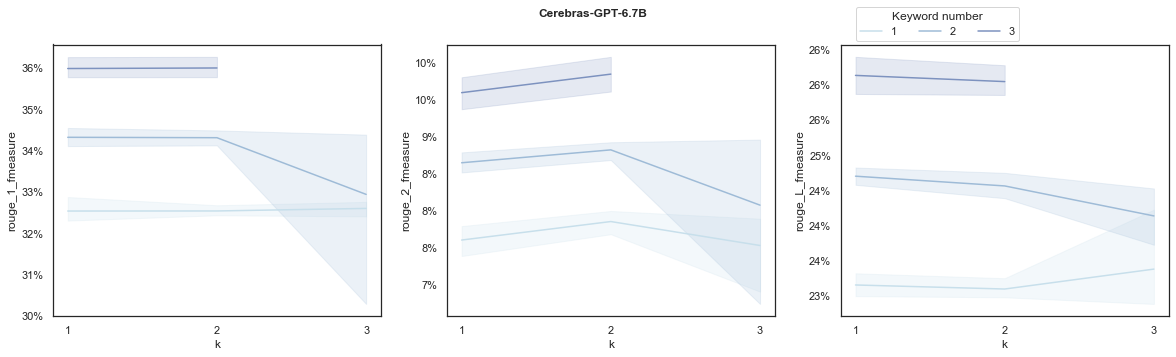

In [19]:
# get the result of MODEL_NAME family
MODEL_NAME = 'Cerebras-GPT-6.7B'

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
else:
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'keywords' in x and 'nameReplace' not in x and 'length' not in x and 'replaceName' not in x]
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'length' in x and 'replaceName' not in x]
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'focus' in x and 'replaceName' not in x]

print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
model_name = rouge_table['model_name'].unique()[0]
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(model_name, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(model_name), dpi=500, bbox_inches='tight')

rouge_table

In [ ]:
mean_df = rouge_table.groupby('k').mean() * 100
mean_df[[x for x in mean_df.columns if 'fmeasure' in x]]

In [ ]:
std_df = rouge_table.groupby('k').std() * 100
std_df[[x for x in std_df.columns if 'fmeasure' in x]]

In [17]:
[x for x in run2metric_table.keys() if 'Cerebras-GPT-6.7B' in x]

['Cerebras-GPT-6.7B-3-shot-2-keywords',
 'Cerebras-GPT-6.7B-1-shot-3-keywords',
 'Cerebras-GPT-6.7B-2-shot-3-keywords',
 'Cerebras-GPT-6.7B-3-shot-1-keywords',
 'Cerebras-GPT-6.7B-2-shot-2-keywords',
 'Cerebras-GPT-6.7B-1-shot-2-keywords',
 'Cerebras-GPT-6.7B-1-shot-1-keywords',
 'Cerebras-GPT-6.7B-2-shot-1-keywords',
 'Cerebras-GPT-6.7B-2-shot',
 'Cerebras-GPT-6.7B-1-shot']

# Get Success Rate

In [20]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['cerebras/Cerebras-GPT-6.7B']

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    if 'nameReplace' in run.name or 'length' in run.name or 'replaceName' in run.name or 'randomLabel' in run.name or 'focus' in run.name:
        continue  
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    print([file.name for file in files])
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) >= 1'.format(metric_file))
        continue 
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/281 [00:00<?, ?it/s]

parsing run Cerebras-GPT-6.7B-3-shot-2-keywords
['artifact/475083096/wandb_manifest.json', 'artifact/475083173/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_9eebc80dcd23ee4c279b.table.json', 'media/table/Summaries Table_1_50dca3262a844019ad90.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
[debug] find keyword_num = 2 in Cerebras-GPT-6.7B-3-shot-2-keywords
parsing run Cerebras-GPT-6.7B-1-shot-3-keywords
['artifact/475115110/wandb_manifest.json', 'artifact/475115186/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_6eb22dae37cce8af8302.table.json', 'media/table/Summaries Table_1_267abbee1f18f6889514.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
[debug] find keyword_num = 3 in Cerebras-GPT-6.7B-1-shot-3-keywords
parsing run Cerebras-GPT-6.7B-2-shot-3-keywords
['artifact/475109301/wandb_manifest.json', 'artifact/475109346/wandb_manifest.json',

{'Cerebras-GPT-6.7B-3-shot-2-keywords':       run_id                                             prompt  \
 0          0  Summarize the conversation with keywords:\nCar...   
 1          0  Summarize the conversation with keywords:\nJus...   
 2          0  Summarize the conversation with keywords:\nDan...   
 3          0  Summarize the conversation with keywords:\nTom...   
 4          0  Summarize the conversation with keywords:\nOti...   
 ...      ...                                                ...   
 2457       3  Summarize the conversation with keywords:\nDer...   
 2458       3  Summarize the conversation with keywords:\nTri...   
 2459       3  Summarize the conversation with keywords:\nJas...   
 2460       3  Summarize the conversation with keywords:\nJak...   
 2461       3  Summarize the conversation with keywords:\nJul...   
 
                                            pred_summary  \
 0     Hannah needs Larry's phone number. Amanda will...   
 1     Eric is watching

In [21]:
run2metric_table.keys()

dict_keys(['Cerebras-GPT-6.7B-3-shot-2-keywords', 'Cerebras-GPT-6.7B-1-shot-3-keywords', 'Cerebras-GPT-6.7B-2-shot-3-keywords', 'Cerebras-GPT-6.7B-3-shot-1-keywords', 'Cerebras-GPT-6.7B-2-shot-2-keywords', 'Cerebras-GPT-6.7B-1-shot-2-keywords', 'Cerebras-GPT-6.7B-1-shot-1-keywords', 'Cerebras-GPT-6.7B-2-shot-1-keywords', 'Cerebras-GPT-6.7B-2-shot', 'Cerebras-GPT-6.7B-1-shot', 'Cerebras-6.7B-3-shot'])

In [22]:
def stem_sentence(sentence):
    if isinstance(sentence, str):
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
    else:
        words = sentence
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    # Stem each word in the sentence
    stemmed_words = [stemmer.stem(word) for word in words]
    # Join the stemmed words back into a sentence
    return stemmed_words

In [23]:
# get the success rate over runs
df = []
missing_keywords2counts = defaultdict(lambda: 0)
included_keywords2counts = defaultdict(lambda: 0)

summary_numerical_num = 0 
response_numerical_num = 0

for run_name, summaries in run2metric_table.items():
    print('[info] parse experiment', run_name)

    summaries['keyword_num'] = summaries['keyword_num'].fillna(0)
    keyword_num = int(summaries['keyword_num'][0])
    if keyword_num <= 0 or 'keywords' not in run_name:
        continue  
    if 'nameReplace' in run_name or 'length' in run_name or 'replaceName' in run_name or 'randomLabel' in run_name or 'focus' in run_name:
        continue 

    model_name = summaries['model_name'][0]
    k = summaries['k'][0]

    for run_id, df_ in summaries.groupby('run_id'):
        print('[info] parse run', run_id)
        keywords_num_total = 0
        included_keywords_num = 0

        # iterate over the run
        for _, row in df_.iterrows():
            is_contains_numeric_gold = any(char.isdigit() for char in row['gold_summary'])
            summary_numerical_num += is_contains_numeric_gold
            is_contains_numeric_pred = any(char.isdigit() for char in row['pred_summary'])
            response_numerical_num += is_contains_numeric_pred
            
            last_line = row['prompt'].split('\n')[-1]
            # parse the keywords
            try:
                start_i, end_i = re.search('\[.+\]', last_line).span()
                keywords = [x.strip()[1:-1] for x in last_line[start_i+1:end_i-1].split(',')]
            except AttributeError:  # mt5 keywords are in different format
                print('[debug] last_line = {}'.format(last_line))
                last_line = re.sub(r'<extra_id_\d+>', '',last_line)
                last_line = last_line.split('Summary: ', maxsplit=1)[-1]
                keywords = [x for x in last_line.split(' ') if len(x.strip()) >= 1]
                if len(keywords) != keyword_num:
                    print('[debug] skip')
                    continue 
            # stem words
            keywords = stem_sentence(keywords)
            gold_summary = stem_sentence(row['pred_summary'])  # fixme: wrong name 
            # check if keywords are included
            keywords_num_total += len(keywords)
            for keyword in keywords:
                if keyword in gold_summary:
                    included_keywords_num += 1
                    included_keywords2counts[keyword] += 1
                else:
                    # print('[miss keywords] {} in sentence: {}'.format(keyword, gold_summary))
                    missing_keywords2counts[keyword] += 1

        # calculate the success rate
        success_rate = included_keywords_num / keywords_num_total
        # print('[{}] success_rate = {}/{} = {}'.format(run_name, included_keywords_num, keywords_num_total, success_rate))
        df.append({
                'model_name': model_name,
                'k': k,
                'keyword_num': keyword_num,
                'success_rate': success_rate,
                'run_id': run_id
                })

print('{} summaries with numerical information and {} responses contain numerical information'.format(summary_numerical_num, response_numerical_num))
df = pd.DataFrame(df)
df

[info] parse experiment Cerebras-GPT-6.7B-3-shot-2-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse experiment Cerebras-GPT-6.7B-1-shot-3-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse run 4
[info] parse experiment Cerebras-GPT-6.7B-2-shot-3-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse run 4
[info] parse experiment Cerebras-GPT-6.7B-3-shot-1-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse experiment Cerebras-GPT-6.7B-2-shot-2-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse run 4
[info] parse experiment Cerebras-GPT-6.7B-1-shot-2-keywords
[info] parse run 0
[info] parse run 1
[info] parse run 2
[info] parse run 3
[info] parse run 4
[info] parse experiment Cerebras-GPT-6.7B-1-shot-1-keywords
[info] parse run 0
[info] parse run 1
[info] par

,model_name,k,keyword_num,success_rate,run_id
0,Cerebras-GPT-6.7B,3,2,0.757021,0
1,Cerebras-GPT-6.7B,3,2,0.758242,1
2,Cerebras-GPT-6.7B,3,2,0.755189,2
3,Cerebras-GPT-6.7B,3,2,0.700000,3
4,Cerebras-GPT-6.7B,1,3,0.737892,0
5,Cerebras-GPT-6.7B,1,3,0.724054,1
6,Cerebras-GPT-6.7B,1,3,0.735450,2
7,Cerebras-GPT-6.7B,1,3,0.738706,3
8,Cerebras-GPT-6.7B,1,3,0.734229,4
9,Cerebras-GPT-6.7B,2,3,0.729752,0


In [ ]:
2923 / 7881 

In [ ]:
# find the ones with numeric values 
for word, counts in missing_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Missing {}, counts = {}'.format(word, counts))

In [ ]:
# find the ones with numeric values 
for word, counts in included_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Including {}, counts = {}'.format(word, counts))

In [ ]:
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=df, x='k', y='success_rate', hue='keyword_num', style='model_name', palette=palette)

plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

plt.savefig('success_rate.jpg', dpi=500, bbox_inches='tight')

In [24]:
df.groupby(['model_name']).mean()

,k,keyword_num,success_rate,run_id
model_name,,,,
Cerebras-GPT-6.7B,1.815789,1.894737,0.761641,1.894737


In [25]:
df.groupby(['model_name']).std()

,k,keyword_num,success_rate,run_id
model_name,,,,
Cerebras-GPT-6.7B,0.76601,0.798291,0.045782,1.390887


# Analyze the numerical keywords

In [ ]:
# load the test dataset
test_dataset = load_dataset('samsum', split='test')
len(test_dataset)

In [ ]:
# find the summaries with numerical information 
summaries_numerical = []
for summary in test_dataset['summary']:
    is_contains_numeric = any(char.isdigit() for char in summary)
    if is_contains_numeric:
        summaries_numerical.append(summary)

print('{} summaries ({}%) with numerical chars'.format(len(summaries_numerical), len(summaries_numerical)/len(test_dataset) * 100))
summaries_numerical

In [ ]:
# get the number of summaries with numerical values
df = []

summary_numerical_num = 0 
response_numerical_num = 0

summary_examples = []
response_examples = [] 

for run_name, summaries in run2metric_table.items():
    if 'nameReplace' in run_name or 'length' in run_name or 'replaceName' in run_name \
        or 'randomLabel' in run_name or 'focus' in run_name or 'instructions' in run_name or 'keywords' in run_name:
        continue
    
    print('[info] parse experiment', run_name)

    summaries['keyword_num'] = summaries['keyword_num'].fillna(0)
    keyword_num = int(summaries['keyword_num'][0])
#     if keyword_num <= 0:
#         continue  

    model_name = summaries['model_name'][0]
    k = summaries['k'][0]

    for run_id, df_ in summaries.groupby('run_id'):
        print('[info] parse run', run_id)
        keywords_num_total = 0
        included_keywords_num = 0

        # iterate over the run
        for _, row in df_.iterrows():
            is_contains_numeric_gold = any(char.isdigit() for char in row['gold_summary'])
            summary_numerical_num += is_contains_numeric_gold
            is_contains_numeric_pred = any(char.isdigit() for char in row['pred_summary'])
            response_numerical_num += is_contains_numeric_pred
            if is_contains_numeric_gold and is_contains_numeric_pred:
                summary_examples.append(row['gold_summary'])
                response_examples.append(row['pred_summary'])

print('{} summaries with numerical information and {} responses contain numerical information ({}%)'.format(summary_numerical_num, response_numerical_num, 
                                                                                                           response_numerical_num / summary_numerical_num * 100))

In [ ]:
summary_examples[:5]

In [ ]:
response_examples[:5]

## Deviation from expected length 

In [ ]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['google/mt5-xl']

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    if 'nameReplace' in run.name:
        continue 
        
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    assert len(metric_file) >= 1
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

In [ ]:

# ks: uncontrolled keys 
# ks = [x for x in run2metric_table.keys() if ('length' not in x and 'keyword' not in x and 'replaceName' not in x)]
# ks: controlled setting 
ks = [x for x in run2metric_table.keys() if ('length' in x)]


length_df = []
for k in ks:
    print('[debug] processing {}'.format(k))
    run_df = run2metric_table[k]
    lengths = []
    
    for _, row in run_df.iterrows():
        words = [word.lower() for word in nltk.word_tokenize(row['gold_summary']) if word not in string.punctuation]
        control_length = len(words)
        
        words = [word.lower() for word in nltk.word_tokenize(row['pred_summary']) if word not in string.punctuation]
        actual_length = len(words)
            
        row['length_error'] = abs(control_length - actual_length)
        row['run_name'] = k
        
        length_df.append(row)
length_df = pd.DataFrame(length_df)
length_df

In [ ]:
length_df.groupby('k').mean()

In [ ]:
ks

In [ ]:
length_df['length_error'].mean()

In [ ]:
length_df['length_error'].std()

# Perplexity

In [ ]:
# iterate over completed runs to get perplexity
run2perplexity = {}

for run in tqdm(runs):
    if 'complete' not in run.tags or getattr(run, 'job_type', '') != 'perplexity_evaluation':
        continue
    else:
        print('parsing run {}'.format(run.name))
        
    files = run.files()
    metric_file = [file for file in files if 'Perplexity Table' in getattr(file, 'name', '')]
    assert len(metric_file) == 1

    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue
    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    if run.name == 'Cerebras-6.7B-3-shot':
        metric_table['model_name'] = 'Cerebras-GPT-6.7B'
    else:
        metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2perplexity[run.name] = metric_table
run2perplexity

In [ ]:
run2perplexity = {k: v for k, v in run2perplexity.items() if 'llama-7b-hf' in k}
run2perplexity.keys()

In [ ]:
perplexity_df = pd.concat(run2perplexity.values(), axis=0, ignore_index=True)
perplexity_df['perplexity'] = pd.to_numeric(perplexity_df['perplexity'])
print('{} infinite values found'.format(sum(perplexity_df['perplexity'].isin([np.inf]))))
perplexity_df = perplexity_df[~perplexity_df['perplexity'].isin([np.inf])]
perplexity_df = perplexity_df.fillna(0)
perplexity_df

In [ ]:
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

In [ ]:
# get the result of MODEL_NAME family
MODEL_NAME = 'llama-7b-hf'

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
else:
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x]
print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0)
model_name = MODEL_NAME
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette, ax=axes[3])
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(MODEL_NAME, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(MODEL_NAME), dpi=500, bbox_inches='tight')

rouge_table

In [ ]:
rouge_table

In [ ]:
dfs = [run2metric_table[k] for k in new_keys]
